In [281]:
import pandas as pd
import requests
import math
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import nan 

## 0) Creating Objects Useful for Further Operations

In [100]:
# Creating a function which will take list as input
# The function with create sub-lists of 100 elements in the whole list
# Since the API requests per minute are capped at 100 we want to iterate with lists of 100 elements per minute

def divide_chunks(input_list):
    
    # Loops starts with 0 till number of stops and hops on to every another 100th element of the list
    
    for i in range(0, len(input_list), 100):
        
        # Indexes from 100 till another 100th element
        # For example indexing at first loop i=0 is [0:100]
        # For second loop the i=100 and indexing is [100:200]
        yield input_list[i:i + 100]

## Exploring Data Based on Different Parameters

### 1) Routes

In [158]:
# Initializing routes data frame which will be populated by below for loop on each api call for every route
df_routes = pd.DataFrame()

# Running a for loop to fetch route information of each bus variant
# We are putting value of route beginning number in the api url to fetch every possible bus variant information
for route in range(0,10):
    response = requests.get(f"https://api.winnipegtransit.com/v3/routes:{route}.json?api-key=wPOIZFdePaV6BdttKD7C")
    response_json = response.json()['routes']
    
    # using json_normalize package to flatten the json type data fetched from the api url
    # A temporary data frame df_each_route will contain information about each route 
    df_each_route = pd.json_normalize(response_json)
    
    # Populating the main dataframe df_routes will each route information through concatenation
    df_routes = pd.concat([df_routes, df_each_route], ignore_index=True)

In [159]:
df_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   key                                 83 non-null     int64 
 1   number                              83 non-null     int64 
 2   name                                83 non-null     object
 3   customer-type                       83 non-null     object
 4   coverage                            83 non-null     object
 5   badge-label                         83 non-null     int64 
 6   variants                            83 non-null     object
 7   badge-style.class-names.class-name  83 non-null     object
 8   badge-style.background-color        83 non-null     object
 9   badge-style.border-color            83 non-null     object
 10  badge-style.color                   83 non-null     object
dtypes: int64(3), object(8)
memory usage: 7.3+ KB


<AxesSubplot:xlabel='number', ylabel='Count'>

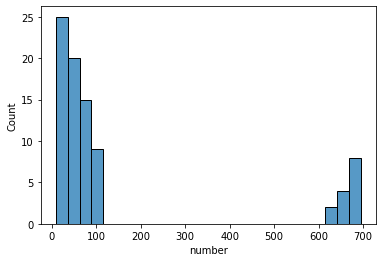

In [160]:
# Checking bus number distribution through a histogram
# Making sure all the bus routes are covered

sns.histplot(x=df_routes['number'])

In [162]:
# Creating a list of routes

routes_list = list(df_routes['number'])
len(routes_list)

83


### 2) Variants of Buses Running in Winnipeg

Background:

There are many bus variants running on Winnipeg's roads. The bus variants are extension to bus route number. For Eg: Route 11 Bus can have variants such as 11-1-M (Portage-Kildonan to City Hall)

Approach For Data Extraction:

We will use wildcard api search for every route number of the bus and find corresponding variants for that

In [174]:
# Initializing our new dataframe which will be concatenated with bus variants values in through our loop
df_variant_main = pd.DataFrame(columns=['key', 'name'])


for route in routes_list:
    # For each bus variant number we are fetching jso format data 
    response = requests.get(f"https://api.winnipegtransit.com/v3/variants:{route}.json?api-key=wPOIZFdePaV6BdttKD7C")
    # capturing only variants information
    variants_list = response.json()['variants']

    # creating a temporary dataframe which will contain contain each bus variant information 
    # this temporary df will be used to concatenate our main dataframe df_variant_main
    df_each_variant = pd.DataFrame(variants_list)
    df_each_variant['Route'] = route

    # Creating main dataframe where all bus varaints will go to
    # Ignoring index to have sequential indexes as per the populated data in the file 
    df_variant_main = pd.concat([df_variant_main, df_each_variant], ignore_index=True)
    

In [175]:
df_variant_main

key                                             name  Route  \
0    11-1-M                    Portage-Kildonan to City Hall   11.0   
1    11-1-D   Portage-Kildonan to North Kildonan via Donwood   11.0   
2    11-0-P                    Portage-Kildonan to Polo Park   11.0   
3    11-1-R  Portage-Kildonan to North Kildonan via Rothesay   11.0   
4    11-1-G                  Portage-Kildonan to Glenway via   11.0   
..      ...                                              ...    ...   
280  97-1-P                                 to Point Douglas   97.0   
281  97-0-F                                          to Fife   97.0   
282  97-1-f                                          to Fife   97.0   
283  93-1-S                              to St. Vital Centre   93.0   
284  93-0-H                        to Highbury & Southfields   93.0   

    description  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
..          ...  
280         NaN  
281         NaN  
282         NaN  
283         NaN  
284         NaN  

[285 rows x 4 columns]

In [176]:
df_variant_main.to_csv('bus_variants.csv')

# 3) Destinations
## Important Landmarks Stops for every bus variant

Background:

For each bus variant, there are some destinations  which are important landmarks which buses on the variant will pass. We are trying to capture this data

Approach for Data Extraction:
The API allows information to be fetched for each single bus variant. Hence, we are running a for loop on the list of bus variants we extracted from above to get our Destinations.


In [177]:
# Creating a list of all bus variants name which we will use in our for loop to extract destinations of all these variants

bus_variants_list = list(df_variant_main['key'])
busvariants_count = len(bus_variants_list)
print(bus_variants_list[:10])
print(f'Number of bus variants are: {busvariants_count}')

['11-1-M', '11-1-D', '11-0-P', '11-1-R', '11-1-G', '11-0-*', '11-0-S', '11-0-C', '11-0-W', '11-1-##']
Number of bus variants are: 285


In [178]:
# Creating a function which will take stops list as input
# The function with create sub-lists of 100 elements in the whole stops list of 4122 stops

def divide_chunks(bus_variants_list):
    
    # Loops starts with 0 till number of stops and hops on to every another 100th element of the list
    
    for i in range(0, busvariants_count, 100):
        
        # Indexes from 100 till another 100th element
        # For example indexing at first loop i=0 is [0:100]
        # For second loop the i=100 and indexing is [100:200]
        yield bus_variants_list[i:i + 100]

In [219]:
# Calling the function and giving it object name bus_variants_chunks
# bus_variants_chunks in coverted list of chunks of list with 100 elements each

chunks_required = math.ceil(busvariants_count/100)
bus_variants_chunks = list(divide_chunks(bus_variants_list))
print(f'Number of bus_stops chunks from original bus stops list: {len(bus_variants_chunks)}')

# Printing count of elements in each chunk index of the new 
for i in range(len(bus_variants_chunks)):
    print(f'Number of elements in chunk index {i}: {len(bus_variants_chunks[i])}')

Number of bus_stops chunks from original bus stops list: 3
Number of elements in chunk index 0: 100
Number of elements in chunk index 1: 100
Number of elements in chunk index 2: 85


In [180]:
# Sample view of how newly created list of bus variants chunks looks like

bus_variants_chunks

[['11-1-M',
  '11-1-D',
  '11-0-P',
  '11-1-R',
  '11-1-G',
  '11-0-*',
  '11-0-S',
  '11-0-C',
  '11-0-W',
  '11-1-##',
  '15-0-W',
  '15-1-I',
  '15-0-L',
  '15-0-F',
  '15-1-C',
  '15-1-L',
  '15-1-#',
  '16-0-s',
  '16-0-B',
  '16-1-P',
  '16-0-M',
  '16-1-##',
  '16-1-V',
  '16-1-L',
  '16-1-*',
  '16-1-K',
  '16-0-*',
  '16-0-K',
  '17-0-A',
  '17-1-MH',
  '17-0-M',
  '17-0-S',
  '17-1-G',
  '12-0-P',
  '12-1-C',
  '18-1-E',
  '18-0-J',
  '18-0-R',
  '18-1-C',
  '18-0-T',
  '18-1-A',
  '19-0-N',
  '19-0-L',
  '19-1-A',
  '19-0-E',
  '19-1-D',
  '19-1-N',
  '19-0-#',
  '10-1-W',
  '10-0-SP',
  '10-1-WT',
  '10-0-ST',
  '10-1-WP',
  '10-1-#',
  '14-0-P',
  '14-1-E',
  '14-0-D',
  '14-1-##',
  '20-0-W',
  '20-1-H',
  '20-1-A',
  '20-0-F',
  '20-1-T',
  '20-1-#',
  '29-0-L',
  '29-1-B',
  '211-0',
  '21-0-S',
  '21-1-D',
  '21-0-W',
  '21-0-C',
  '21-0-G',
  '22-1-D',
  '22-0-C',
  '22-0-W',
  '22-0-S',
  '24-1-D',
  '24-0-U',
  '24-1-P',
  '24-1-#',
  '26-0-P',
  '26-1-C',
  '26-0-T

In [203]:
# Creating a function which will go inside in each bus_variants_chunks list elements
# And make an api call for each bus variant chunkwise

# Initializing with an empty pandas dataframe which will populate with each api call
df_destinations_per_chunk = pd.DataFrame()


# This function takes in chunk_index(what chunk of the whole list to work on)
# Then for each chunk index makes api calls of bus variants in that chunk

def bus_variants_chunkwise(chunk_index):
    
    # Declaring the initialized dataframe variable df_stop_features as a global variable
    # Without it the function will consider it to be local variable and not work
    global df_destinations_per_chunk
    
    # Running a for loop to make api call for each stop in the bus_stops_chunks list
    for variant in bus_variants_chunks[chunk_index]:
        response = requests.get(f"https://api.winnipegtransit.com/v3/variants/{variant}/destinations.json?api-key=wPOIZFdePaV6BdttKD7C")
        
        try:
            # Recording the information got into a temporary frame df_each_stop_features
            json_format = response.json()['destinations']
            df_each_stop_destinations = pd.json_normalize(json_format)
            df_each_stop_destinations['Bus_Variant'] = variant

            # Simulatenous concatanetion of each stop's info in df_stop_feature_chunk
            # This dataframe will contain records for each chunk of the big 4122 stops list
            df_destinations_per_chunk = pd.concat([df_destinations_per_chunk, df_each_stop_destinations], ignore_index=True)
        
        except:
            df_each_stop_destinations['Bus_Variant'] = variant
            df_each_stop_destinations['key'] = ''
            df_each_stop_destinations['name'] = ''

In [297]:
df_destinations_per_chunk = pd.DataFrame()
for variant in bus_variants_chunks[chunk_index]:
    try:
        
        response = requests.get(f"https://api.winnipegtransit.com/v3/variants/{variant}/destinations.json?api-key=wPOIZFdePaV6BdttKD7C")
        json_format = response.json()['destinations']
        if json_format != []:
            
            # Recording the information got into a temporary frame df_each_stop_features
            df_each_stop_destinations = pd.json_normalize(json_format)
            df_each_stop_destinations['Bus_Variant'] = variant

            # Simulatenous concatanetion of each stop's info in df_stop_feature_chunk
            
        
        else:
            df_each_stop_destinations['Bus_Variant'] = variant
            df_each_stop_destinations['key'] = None
            df_each_stop_destinations['name'] = None
    except:
        print(f'{variant} not added')
        df_each_stop_destinations['Bus_Variant'] = variant
        df_each_stop_destinations['key'] = None
        df_each_stop_destinations['name'] = None
    # This dataframe will contain records for each chunk of the big 4122 stops list
     
    df_destinations_per_chunk = pd.concat([df_destinations_per_chunk, df_each_stop_destinations], ignore_index=True)

11-1-## not added
15-1-# not added
16-1-## not added
19-0-N not added
19-0-# not added
10-1-# not added
14-1-## not added
20-1-# not added
24-1-# not added


In [301]:
print(df_destinations_per_chunk.Bus_Variant.nunique())
df_destinations_per_chunk.to_csv('chunk_info.csv')

100


In [296]:
response = requests.get(f"https://api.winnipegtransit.com/v3/variants/24-1-#/destinations.json?api-key=wPOIZFdePaV6BdttKD7C")
json_format = response.json()['destinations']
json_format == []

JSONDecodeError: [Errno Expecting value] Invalid API Key: 0

In [237]:
# Initializng with index 0

chunk_index=0

# Initializing empty dataframe which will contain bus destinations of all bus variants
# This is our final outcome 

df_bus_destinations = pd.DataFrame()

# Creating a function to repeadtly execute above created function bus_stop_features_chunkwise
# On every run chunk_index increases by 1 
# We will repeadtly make calls of this function in 60 secods intervals

# This function merely runs the previous function and takes in index number of chunk list
def bus_destinations(index):
    
    # Declaring chunk_index and chunks_required variable as global as its referenced before the function
    global chunk_index
    global chunks_required
    global df_bus_destinations
    
    
    # The loop will run until the index_count reaches equal to chunks_required
    # which is number of bus stops in our list divided by 100 elements' chunks)
    if chunk_index <= chunks_required:
        
        # Using a for loop to call run bus_stop_features_chunkwise for each index position
        
        for i in [chunk_index]:
            bus_variants_chunkwise(chunk_index=chunk_index)
            
            # For each loop, index value be incremented by 1 which becomes input when function is run again
            chunk_index+=1
            
            # Concatenating with main dataframe
            df_bus_destinations = pd.concat([df_bus_destinations, df_destinations_per_chunk], ignore_index=True)
            
        print(f'Chunk index {i} of Bus Destinations List Added to Dataframe at {time.ctime()}')
        print(f'Number of Variants added {df_bus_destinations.Bus_Variant.nunique()}')
        
    else:
        print('Every Bus Destination put into the dataframe. Process complete')
        

In [228]:
bus_destinations(index=0)

Chunk index 0 of Bus Destinations List Added to Dataframe at Sun Nov 13 18:27:09 2022
Number of Variants added 186


In [214]:
# Importing schedule library for scheduling tasks

import schedule
import time

# Creating a schedule object which will run the bus_stops_features function at every 60 seconds intreval
# We also have defined the index to start with, i.e 0 which will initialized above
schedule.clear()
schedule.every(60).seconds.do(bus_destinations, index=chunk_index)

# Checking pending jobs

schedule.get_jobs()

[Every 60 seconds do bus_destinations(index=0) (last run: [never], next run: 2022-11-13 18:19:22)]

In [215]:
# Running a while loop which will keep the scheduled job running at 1 minute intervals
# The scheduled job will run until the all chunks in the bus variants list are looped and entered into dataframe


# The loop will run until chunk_index(which is incrementing by 1 on every loop) reaches the equal to (number of chunks + 1)
# We have 3 chunks_required (sub-lists of 100 bus variants) in our whole 206 bus_variants_list
# The while loop stops when chunk_index rises to value greater than required chunks

while chunk_index <= chunks_required:
    
    # If statement runs until all chunk indexes are looped, which in our case is 41
    if chunk_index <= (chunks_required-1):
        schedule.run_pending()
    
    # Once the index reaches 2 and increments to 3, it means we have looped all the chunks 
    # Scheduler stops there
    else:
        # Clearing pending schedules after job is done
        schedule.clear()
        print('Scheduler Stopped. Process Complete ')
        break
        

Chunk index 0 of Bus Destinations List Added to Dataframe at Sun Nov 13 18:19:54 2022
Number of Variants added 186


KeyboardInterrupt: 

In [216]:
df_bus_destinations.to_csv('Bus_Destinations.csv')

# 4) Locations
## Getting locations of buses

In [57]:
# Checking search results for 'downtown' query

response = requests.get("https://api.winnipegtransit.com/v3/locations:downtown.json?api-key=wPOIZFdePaV6BdttKD7C")
a = response.json()['locations']
# Here we are creating a seperate dataframe to keep a check on the query time also
df_locations = pd.DataFrame.from_records(a)
df_locations


key                           name  \
0  10966                   Downtown Biz   
1   4408             Quest Inn Downtown   
2  11248                ACCESS Downtown   
3   2231  Smoke's Poutinerie - Downtown   
4   5032             The Bay - Downtown   

                                 categories  \
0      [Entertainment: Tourist Attractions]   
1            [Entertainment: Hotels/Motels]   
2  [Government: Manitoba, Clinics: Medical]   
3              [Entertainment: Restaurants]   
4                     [Shops: Major Stores]   

                                             address      type  
0  {'key': 137345, 'street-number': 426, 'street'...  monument  
1  {'key': 147099, 'street-number': 367, 'street'...  monument  
2  {'key': 218029, 'street-number': 640, 'street'...  monument  
3  {'key': 142798, 'street-number': 131, 'street'...  monument  
4  {'key': 137347, 'street-number': 450, 'street'...  monument

In [58]:
a = response.json()['locations'][0]
a

{'key': 10966,
 'name': 'Downtown Biz',
 'categories': ['Entertainment: Tourist Attractions'],
 'address': {'key': 137345,
  'street-number': 426,
  'street': {'key': 2903, 'name': 'Portage Avenue', 'type': 'Avenue'},
  'centre': {'utm': {'zone': '14U', 'x': 632958, 'y': 5528183},
   'geographic': {'latitude': '49.89126', 'longitude': '-97.1489'}}},
 'type': 'monument'}

In [59]:
# Importing json_normalize package which will make transformation of json object to pandas dataframe easier

from pandas.io.json import json_normalize
json_normalize(a)

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_4312/3543066072.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  json_normalize(a)


key          name                            categories      type  \
0  10966  Downtown Biz  [Entertainment: Tourist Attractions]  monument   

   address.key  address.street-number  address.street.key address.street.name  \
0       137345                    426                2903      Portage Avenue   

  address.street.type address.centre.utm.zone  address.centre.utm.x  \
0              Avenue                     14U                632958   

   address.centre.utm.y address.centre.geographic.latitude  \
0               5528183                           49.89126   

  address.centre.geographic.longitude  
0                            -97.1489

## Observation

Location data is based on user search for an address or landmark and the api locations will give the gps coordintes of the searched location. We right now don't find this dataframe much useful as the results are based on our location searches and locations are unlimited.
Keeping this for further use.

# 5) Service Advisories

## Contains advisories issued by Winnipeg Transit current and prior for this year

In [169]:
# Calling service advisories data from the api

response = requests.get("https://api.winnipegtransit.com/v3/service-advisories.json?api-key=wPOIZFdePaV6BdttKD7C")
a = response.json()['service-advisories']
df_service_advisories = json_normalize(a)
df_service_advisories

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_9760/35264724.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_service_advisories = json_normalize(a)


key  priority                                      title  \
0  5213         3                         (SEP 19/22) Flight   
1  5197         3       (SEP 12/22) 649, 691 Chevrier Detour   
2  5128         3  (JUL 10/22) 33 route , WB William Closure   
3  5007         3            (DEC 27/21) 635 Wolseley detour   

                                                body category  \
0  As of Sep 19, 2022 09:00, route 15 is under th...  Transit   
1  As of Sep 12, 2022 11:30, route 649 is under t...  Transit   
2  As of Jul 10, 2022 10:00, routes 33 and 35 are...  Transit   
3  As of Apr 17, 2022 03:00, route 635 is under t...  Transit   

            updated-at              type  
0  2022-09-19T09:03:02  service-advisory  
1  2022-09-12T12:35:37  service-advisory  
2  2022-07-10T10:59:53  service-advisory  
3  2022-04-11T14:53:40  service-advisory

#### Note: Priority column shows service advisories of this priority or higher (where 1 is high, and 5 is low)

In [170]:
# Checking one sample body text of the first advisory in the data 

df_service_advisories['body'][0]

'As of Sep 19, 2022 09:00, route 15 is under the effects of a detour. This detour affects the following stops:\n\n* 20122 - Southbound Flight at Sargent\n* 20123 - Eastbound Sargent at Ferry East\n* 20144 - Eastbound Sargent at Berry\n* 20502 - Eastbound Sargent at Ferry\n\nReroutes are as follows:\n\n* **Routes 15 (Sargent-Mountain to Downtown), 15 (Sargent-Mountain to Inkster Park via Church), 15 (Sargent-Mountain to Inkster Park via Inkster) and 15 (Sargent-Mountain to Mountain & Fife)** from Wellington Avenue will reroute following these instructions:\n** Travel along Wellington Avenue and turn south on to Berry Street\n** Continue along Berry Street and turn east on to Sargent Avenue\n** Return to regular service'

# 6) Status

## Shows current status under which transit is operating

In [171]:
# Extracting status data from the api

response = requests.get("https://api.winnipegtransit.com/v3/statuses.json?api-key=wPOIZFdePaV6BdttKD7C")
a = response.json()['statuses']
df_status = json_normalize(a)
df_status

C:\Users\AKSHAY~1\AppData\Local\Temp/ipykernel_9760/2839442592.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_status = json_normalize(a)


name    value                                      description  \
0   omnibus   normal  The current status of the Omnibus Web Services.   
1  schedule  regular                                              NaN   

            updated-at                                            message  
0  2022-11-13T17:23:50                                                NaN  
1                  NaN  Winnipeg Transit is currently operating regula...

# 7) Stops

## Bus stops information

Background on Data: For each bus variant, information about each stop that it services is available. We can obtain various attributes of each bus stop against each bus variant through this.

Metholodology for Data Extraction: For every bus variant out of 206 variants we will make an api request and populate our dataframe. We will do this in chunks of 100 variants per minute to avoid server overload.

In [197]:
# Creating a function which will go inside in each bus_variants_chunks list elements
# And make an api call for each bus variant chunkwise

# Initializing with an empty pandas dataframe which will populate with each api call
df_stops_per_chunk = pd.DataFrame()


# This function takes in chunk_index(what chunk of the whole list to work on)
# Then for each chunk index makes api calls of bus variants in that chunk

def bus_stops_chunkwise(chunk_index):
    
    # Declaring the initialized dataframe variable df_stop_features as a global variable
    # Without it the function will consider it to be local variable and not work
    global df_stops_per_chunk
    
    # Running a for loop to make api call for each stop in the bus_stops_chunks list
    for variant in bus_variants_chunks[chunk_index]:
        response = requests.get(f"https://api.winnipegtransit.com/v3/stops.json?api-key=wPOIZFdePaV6BdttKD7C&variant={variant}")
        
        try:
            # Recording the information got into a temporary frame df_each_stop_features
            json_format = response.json()['stops']
            df_each_variant_stops = pd.json_normalize(json_format)
            df_each_variant_stops['Bus_Variant'] = variant

            # Simulatenous concatanetion of each stop's info in df_stop_feature_chunk
            # This dataframe will contain records for each chunk of the big 4122 stops list
            df_stops_per_chunk = pd.concat([df_stops_per_chunk, df_each_variant_stops], ignore_index=True)
        
        except:
            print('Problem Detected')
            df_each_variant_stops['Bus_Variant'] = variant
            df_each_variant_stops['key'] = ''
            df_each_variant_stops['name'] = ''

In [196]:
# Initializng with index 0

chunk_index=0

# Initializing empty dataframe which will contain bus destinations of all bus variants
# This is our final outcome 

df_bus_stops = pd.DataFrame()

# Creating a function to repeadtly execute above created function bus_stop_features_chunkwise
# On every run chunk_index increases by 1 
# We will repeadtly make calls of this function in 60 secods intervals

# This function merely runs the previous function and takes in index number of chunk list
def bus_stops(index):
    
    # Declaring chunk_index and chunks_required variable as global as its referenced before the function
    global chunk_index
    global chunks_required
    global df_bus_stops
    
    # The loop will run until the index_count reaches equal to chunks_required
    # which is number of bus stops in our list divided by 100 elements' chunks)
    if chunk_index <= chunks_required:
        
        # Using a for loop to call run bus_stop_features_chunkwise for each index position
        
        for i in [chunk_index]:
            # Calling function to build dataframe out of of current chunk_index of the bus_variants_chunk list
            bus_stops_chunkwise(chunk_index=chunk_index)
            
            # For each loop, index value be incremented by 1 which becomes input when function is run again
            chunk_index+=1
            
            # Concatenating with main dataframe
            df_bus_stops = pd.concat([df_bus_stops, df_stops_per_chunk], ignore_index=True)
        
        print(f'Chunk index {i} of Bus Stops List Added to Dataframe at {time.ctime()}')
        
    else:
        print('Every Bus Stop put into the dataframe. Process complete')
        

In [198]:
# Importing schedule library for scheduling tasks

import schedule
import time

# Creating a schedule object which will run the bus_stops_features function at every 60 seconds intreval
# We also have defined the index to start with, i.e 0 which will initialized above
schedule.clear()
schedule.every(60).seconds.do(bus_stops, index=chunk_index)

# Checking pending jobs

schedule.get_jobs()

# Running a while loop which will keep the scheduled job running at 1 minute intervals
# The scheduled job will run until the all chunks in the bus variants list are looped and entered into dataframe


# The loop will run until chunk_index(which is incrementing by 1 on every loop) reaches the equal to (number of chunks + 1)
# We have 3 chunks_required (sub-lists of 100 bus variants) in our whole 206 bus_variants_list
# The while loop stops when chunk_index rises to value greater than required chunks

while chunk_index <= chunks_required:
    
    # If statement runs until all chunk indexes are looped, which in our case is 41
    if chunk_index <= (chunks_required-1):
        schedule.run_pending()
    
    # Once the index reaches 2 and increments to 3, it means we have looped all the chunks 
    # Scheduler stops there
    else:
        # Clearing pending schedules after job is done
        schedule.clear()
        print('Scheduler Stopped. Process Complete ')
        break
        

Chunk index 0 of Bus Stops List Added to Dataframe at Fri Nov 11 19:51:32 2022
          key                                           name   number  \
0     50096.0     Eastbound St.Amant Access at St.Amant East  50096.0   
1     50443.0                   Eastbound Riel at St. Mary's  50443.0   
2     50445.0                    Eastbound Riel at Robertson  50445.0   
3     50447.0                       Eastbound Riel at Darwin  50447.0   
4     50448.0                         Eastbound Riel at Metz  50448.0   
...       ...                                            ...      ...   
5419  50899.0         Northbound Burning Glass at Sage Creek  50899.0   
5420  50990.0  Northbound Burning Glass at Dr. David Friesen  50990.0   
5421  50991.0          Eastbound Sage Creek at Solstice Lane  50991.0   
5422  50992.0                Eastbound Sage Creek at Charity  50992.0   
5423  50993.0                    Westbound Warde at Red Lily  50993.0   

       direction      side  street.key      

Chunk index 2 of Bus Stops List Added to Dataframe at Fri Nov 11 19:54:10 2022
           key                                        name   number  \
0      50096.0  Eastbound St.Amant Access at St.Amant East  50096.0   
1      50443.0                Eastbound Riel at St. Mary's  50443.0   
2      50445.0                 Eastbound Riel at Robertson  50445.0   
3      50447.0                    Eastbound Riel at Darwin  50447.0   
4      50448.0                      Eastbound Riel at Metz  50448.0   
...        ...                                         ...      ...   
26166  61079.0                Westbound Eldridge at Dieppe  61079.0   
26167  61080.0              Westbound Eldridge at Harstone  61080.0   
26168  61081.0                Westbound Rannock at Bingham  61081.0   
26169  61086.0  Southbound William Clement at Roblin South  61086.0   
26170  61133.0                Westbound Eldridge at Hewitt  61133.0   

        direction              side  street.key              street.

In [200]:
df_bus_stops.to_csv('Bus_Stops.csv')

In [201]:
bus_variants_list

['16-0-s',
 '1-0',
 '11-1-M',
 '10-1-W',
 '10-0-SP',
 '10-1-WT',
 '10-0-ST',
 '10-1-WP',
 '10-1-#',
 '11-1-D',
 '11-0-P',
 '11-1-R',
 '11-1-G',
 '11-0-*',
 '11-0-S',
 '11-0-C',
 '11-0-W',
 '11-1-##',
 '12-0-P',
 '12-1-C',
 '14-0-P',
 '14-1-E',
 '14-0-D',
 '14-1-##',
 '15-0-W',
 '2-0',
 '211-0',
 '20-0-W',
 '20-1-H',
 '20-1-A',
 '20-0-F',
 '20-1-T',
 '20-1-#',
 '21-0-S',
 '21-1-D',
 '21-0-W',
 '21-0-C',
 '21-0-G',
 '22-1-D',
 '22-0-C',
 '22-0-W',
 '22-0-S',
 '23-0-A',
 '23-1-C',
 '24-1-D',
 '24-0-U',
 '24-1-P',
 '24-1-#',
 '25-0-U',
 '25-1-D',
 '36-1-C',
 '30-0-I',
 '30-1-D',
 '31-1-D',
 '31-0-M',
 '31-0-O',
 '32-0-L',
 '32-1-D',
 '32-0-R',
 '33-0-J',
 '33-1-D2',
 '33-0-M',
 '33-1-D',
 '33-1-Mc',
 '34-1-D',
 '34-0-M',
 '35-1-C',
 '35-0-A',
 '36-0-U',
 '36-1-M',
 '38-0-T',
 '38-1-F',
 '40-1-D',
 '40-0-S',
 '41-1-D',
 '41-0-G',
 '41-0-N',
 '42-0-L',
 '42-1-D',
 '43-0-K',
 '43-1-D',
 '44-0-M',
 '44-1-L',
 '44-0-L',
 '44-1-M',
 '44-1-#',
 '44-1-*',
 '45-0-K',
 '45-1-D',
 '45-0-M',
 '46-1-D'

In [69]:
# Initializing an empty dataframe which will contain stops of all bus variants
df_stops = pd.DataFrame()

# Creating a list object containing bus variants whose query search didn't return any result
variants_without_stops = []


# Creating a for loop which will fetch stops data for each bus variant from the api url
# Please note that the loop will run in two parts to avoid overload of winnipeg transit's server
# The server allows for 100 requests per minute only
# Since we have 206 bus variants we will run the loop in two parts 
# for each variant we are creating a request on the api

for bus_variant in bus_variants_list[:100]:
    response = requests.get(f"https://api.winnipegtransit.com/v3/stops.json?api-key=wPOIZFdePaV6BdttKD7C&variant={bus_variant}")
    
    # Creating a check on error server response
    # this condition will print out server error wherever any fetch finds error 
    
    if response.reason == 'OK':
        json_format = response.json()['stops']
    
        # Creating a temporary dataframe df_stops_each_variant which will updated with stops of bus variant on each loop
        # This will be used in concatenating each bus variant's stop info in the main dataframe df_stops
        df_stops_each_variant = pd.json_normalize(json_format)
         
        # Populating bus_variant column with bus variant number value to give the dataframe a unique identifier
        df_stops_each_variant['bus_variant'] = bus_variant
    
        # Concatenating each bus variant's info to main dataframe with bus stops information
        df_stops = pd.concat([df_stops, df_stops_each_variant], ignore_index=True)

    
    else:
        print(f"Bus variant {bus_variant} returned server error while fetching data")
        # Populating a list of bus variants for which destinations couldn't be fetched
        variants_without_stops.append(bus_variant)

In [70]:
# Checking the result of populated dataframe with first 100 bus variants in our list

df_stops

key                                           name   number  \
0     50096.0     Eastbound St.Amant Access at St.Amant East  50096.0   
1     50443.0                   Eastbound Riel at St. Mary's  50443.0   
2     50445.0                    Eastbound Riel at Robertson  50445.0   
3     50447.0                       Eastbound Riel at Darwin  50447.0   
4     50448.0                         Eastbound Riel at Metz  50448.0   
...       ...                                            ...      ...   
5419  50899.0         Northbound Burning Glass at Sage Creek  50899.0   
5420  50990.0  Northbound Burning Glass at Dr. David Friesen  50990.0   
5421  50991.0          Eastbound Sage Creek at Solstice Lane  50991.0   
5422  50992.0                Eastbound Sage Creek at Charity  50992.0   
5423  50993.0                    Westbound Warde at Red Lily  50993.0   

       direction      side  street.key           street.name street.type  \
0      Eastbound  Nearside  50000271.0       St.Amant Access        Road   
1      Eastbound  Nearside      3047.0           Riel Avenue      Avenue   
2      Eastbound  Nearside      3047.0           Riel Avenue      Avenue   
3      Eastbound  Nearside      3047.0           Riel Avenue      Avenue   
4      Eastbound   Farside      3047.0           Riel Avenue      Avenue   
...          ...       ...         ...                   ...         ...   
5419  Northbound  Nearside      4340.0    Burning Glass Road        Road   
5420  Northbound  Nearside      4340.0    Burning Glass Road        Road   
5421   Eastbound  Nearside      4339.0  Sage Creek Boulevard   Boulevard   
5422   Eastbound  Nearside      4339.0  Sage Creek Boulevard   Boulevard   
5423   Westbound   Farside      3780.0          Warde Avenue      Avenue   

      cross-street.key        cross-street.name cross-street.type  \
0               3059.0               River Road              Road   
1               3453.0           St Mary's Road              Road   
2               3086.0       Robertson Crescent          Crescent   
3                976.0            Darwin Street            Street   
4               2485.0              Metz Street            Street   
...                ...                      ...               ...   
5419            4339.0     Sage Creek Boulevard         Boulevard   
5420            4441.0  Dr. David Friesen Drive             Drive   
5421            4430.0            Solstice Lane              Lane   
5422            4432.0             Charity Lane              Lane   
5423            4428.0            Red Lily Road              Road   

     centre.utm.zone  centre.utm.x  centre.utm.y centre.geographic.latitude  \
0                14U      634410.0     5519913.0                   49.81659   
1                14U      635587.0     5521034.0                    49.8264   
2                14U      635477.0     5520973.0                   49.82588   
3                14U      635228.0     5520832.0                   49.82467   
4                14U      635047.0     5520729.0                   49.82378   
...              ...           ...           ...                        ...   
5419             14U      640552.0     5521920.0                   49.83322   
5420             14U      640549.0     5522086.0                   49.83471   
5421             14U      641262.0     5521917.0                   49.83303   
5422             14U      641547.0     5521788.0                    49.8318   
5423             14U      641145.0     5521315.0                   49.82764   

     centre.geographic.longitude bus_variant cross-street.leg street.leg  
0                      -97.13157      16-0-s              NaN        NaN  
1                      -97.11482      16-0-s              NaN        NaN  
2                      -97.11637      16-0-s              NaN        NaN  
3                      -97.11988      16-0-s              NaN        NaN  
4                      -97.12243      16-0-s              NaN      

In [71]:
# Running the for loop for the balance bus variants

for bus_variant in bus_variants_list[100:]:
    response = requests.get(f"https://api.winnipegtransit.com/v3/stops.json?api-key=wPOIZFdePaV6BdttKD7C&variant={bus_variant}")
    
    # Creating a check on error server response
    # this condition will print out server error wherever any fetch finds error 
    
    if response.reason == 'OK':
        json_format = response.json()['stops']
    
        # Creating a temporary dataframe df_stops_each_variant which will updated with stops of bus variant on each loop
        # This will be used in concatenating each bus variant's stop info in the main dataframe df_stops
        df_stops_each_variant = pd.json_normalize(json_format)
         
        # Populating bus_variant column with bus variant number value to give the dataframe a unique identifier
        df_stops_each_variant['bus_variant'] = bus_variant
    
        # Concatenating each bus variant's info to main dataframe with bus stops information
        df_stops = pd.concat([df_stops, df_stops_each_variant], ignore_index=True)

    
    else:
        print(f"Bus variant {bus_variant} returned server error while fetching data")
        # Populating a list of bus variants for which destinations couldn't be fetched
        variants_without_stops.append(bus_variant)

In [72]:
# We observe the change in the dataframe. It has now 10505 records which is our final dataframe 
# Containing bus stops information

df_stops

key                                        name   number  \
0      50096.0  Eastbound St.Amant Access at St.Amant East  50096.0   
1      50443.0                Eastbound Riel at St. Mary's  50443.0   
2      50445.0                 Eastbound Riel at Robertson  50445.0   
3      50447.0                    Eastbound Riel at Darwin  50447.0   
4      50448.0                      Eastbound Riel at Metz  50448.0   
...        ...                                         ...      ...   
10500  61079.0                Westbound Eldridge at Dieppe  61079.0   
10501  61080.0              Westbound Eldridge at Harstone  61080.0   
10502  61081.0                Westbound Rannock at Bingham  61081.0   
10503  61086.0  Southbound William Clement at Roblin South  61086.0   
10504  61133.0                Westbound Eldridge at Hewitt  61133.0   

        direction              side  street.key              street.name  \
0       Eastbound          Nearside  50000271.0          St.Amant Access   
1       Eastbound          Nearside      3047.0              Riel Avenue   
2       Eastbound          Nearside      3047.0              Riel Avenue   
3       Eastbound          Nearside      3047.0              Riel Avenue   
4       Eastbound           Farside      3047.0              Riel Avenue   
...           ...               ...         ...                      ...   
10500   Westbound           Farside      1211.0          Eldridge Avenue   
10501   Westbound          Nearside      1211.0          Eldridge Avenue   
10502   Westbound  Farside Opposite      2988.0           Rannock Avenue   
10503  Southbound           Farside      4509.0  William Clement Parkway   
10504   Westbound          Nearside      1211.0          Eldridge Avenue   

      street.type  cross-street.key   cross-street.name cross-street.type  \
0            Road            3059.0          River Road              Road   
1          Avenue            3453.0      St Mary's Road              Road   
2          Avenue            3086.0  Robertson Crescent          Crescent   
3          Avenue             976.0       Darwin Street            Street   
4          Avenue            2485.0         Metz Street            Street   
...           ...               ...                 ...               ...   
10500      Avenue            1053.0         Dieppe Road              Road   
10501      Avenue            1662.0       Harstone Road              Road   
10502      Avenue             367.0       Bingham Drive             Drive   
10503     Parkway            3091.0    Roblin Boulevard         Boulevard   
10504      Avenue            1732.0     Hewitt Crescent          Crescent   

      centre.utm.zone  centre.utm.x  centre.utm.y centre.geographic.latitude  \
0                 14U      634410.0     5519913.0                   49.81659   
1                 14U      635587.0     5521034.0                    49.8264   
2                 14U      635477.0     5520973.0                   49.82588   
3                 14U      635228.0     5520832.0                   49.82467   
4                 14U      635047.0     5520729.0                   49.82378   
...               ...           ...           ...                        ...   
10500             14U      623392.0     5523738.0                   49.85334   
10501             14U      623189.0     5523745.0                   49.85345   
10502             14U      621345.0     5523367.0                   49.85043   
10503             14U      624519.0     5524889.0                   49.86346   
10504             14U      624836.0     5523688.0                   49.85259   

      centre.geographic.longitude bus_variant cross-street.leg street.leg  
0                       -97.13157      16-0-s              NaN        NaN  
1                       -97.11482      16-0-s              NaN        NaN  
2                       -97.11637      16-0-s              NaN        NaN  
3                       -97.11988      16-0-s          

In [73]:
# Changing the datatype to int to remove the decimal from stop number
df_stops_number = df_stops['number'].astype(int)
df_stops_number

0        50096
1        50443
2        50445
3        50447
4        50448
         ...  
10500    61079
10501    61080
10502    61081
10503    61086
10504    61133
Name: number, Length: 10505, dtype: int32

In [304]:
# Creating a str data type list of stop number which will be useful in fetching further information
# Changing the dataframe to set datatype first to remove duplicates and then converting to list

stop_numbers_list = list(set(df_stops_number))

In [305]:
number_of_stops = len(stop_numbers_list)
number_of_stops

4122

# 8) Stops' Features
## Getting Stops Features Through Stops List

## Situation

We have a big list of 4122 bus stops and for each stop we need to make a seperate api call to fetch bus stop features data for each bus stop

Since the limit to api calls are 100 requests per minute on Winnipeg Transit Website, for 4122 requests we have to explore different way

## Solution

We will covert the bus stops list into lists of smaller lists(chunks) of 100s  bus stops and have to make calls in chunks of 100 bus stops at 60 seconds intervals

This way we can make api calls for every chunk of 100 bus stops in the big list of 4122 elements 

## Proposed Roadmap for the Solution

### Step 1

Create a function called 'divide_chunks' to convert 'stop_numbers_list' into a list of smaller lists (of 100 bus stops each). We will call the resultant list 'bus_stops_chunks'

### Step 2

a) Create a function called 'bus_stop_features_chunkwise' which will run a loop to get inside every element in the 'bus_stops_chunks' list and will make an api call for each bus stop. 

b) The function will start relies on chunk_index which is starting point in the bus_stops_chunk list. For each loop, the chunk_index will increment by 1.

c) So when the function is run again after 60 seconds intreval, the loop is run on next chunk of the 'bus_stops_chunks' list.

d) The data will be transferred to 'df_stop_features_per_chunk' DataFrame

### Step 3 

a) Create a function 'bus_stops_features' to run the above function for each chunk_index value which is incrementing by 1 in every run of the function 'bus_stop_features_chunkwise'

b) On every loop the data of each chunk will be pushed to 'df_stop_features' DataFrame

### Step 4

Create a schedule to run the function 'bus_stops_features' in every 60 seconds intrevals and stop after all chunk_indexes are covered in the bus_stops_list



In [306]:


# For 4122 bus stops we would need 4122/100 number of chunks
chunks_required = round(number_of_stops/100)

# Creating a function which will take stops list and chunks required as input
# The function with create sub-lists of 100 elements in the whole stops list of 4122 stops

def divide_chunks(stop_numbers_list,chunks_required):
    
    # Loops starts with 0 till number of stops and hops on to every another 100th element of the list
    
    for i in range(0, number_of_stops, 100):
        
        # Indexes from 100 till another 100th element
        # For example indexing at first loop i=0 is [0:100]
        # For second loop the i=100 and indexing is [100:200]
        yield stop_numbers_list[i:i + 100]


In [307]:
# Calling the function and giving it object name bus_stop_chunks
# Bus_stop_chunks in coverted list of chunks of list with 100 elements each

bus_stops_chunks = list(divide_chunks(stop_numbers_list, chunks_required))
print(f'Number of bus_stops chunks from original bus stops list: {len(bus_stops_chunks)}')
print(f'Number of elements in each chunk: {len(bus_stops_chunks[0])}')

Number of bus_stops chunks from original bus stops list: 42
Number of elements in each chunk: 100


In [308]:
# Creating a function which will go inside in each bus_stop chunk list elements
# And make an api call for each bus stop

# Initializing with an empty pandas dataframe which will populate with each api call
df_stop_features_per_chunk = pd.DataFrame()


# This function takes in chunk_index(what chunk of the whole list to work on)
# Then for each chunk makes api calls of bus stops in that chunk

def bus_stop_features_chunkwise(chunk_index):
    
    # Declaring the initialized dataframe variable df_stop_features as a global variable
    # Without it the function will consider it to be local variable and not work
    global df_stop_features_per_chunk
    
    # Running a for loop to make api call for each stop in the bus_stops_chunks list
    for stop in bus_stops_chunks[chunk_index]:
        response = requests.get(f"https://api.winnipegtransit.com/v3/stops/{stop}/features.json?api-key=wPOIZFdePaV6BdttKD7C")
        
        # Recording the information got into a temporary frame df_each_stop_features
        json_format = response.json()['stop-features']
        df_each_stop_features = pd.json_normalize(json_format)
        df_each_stop_features['Stop_Number'] = stop
        
        # Simulatenous concatanetion of each stop's info in df_stop_feature_chunk
        # This dataframe will contain records for each chunk of the big 4122 stops list
        df_stop_features_per_chunk = pd.concat([df_stop_features_per_chunk,df_each_stop_features], ignore_index=True)
        
        
        

In [410]:
# Initializng with index 0

chunk_index=0

# Initializing empty dataframe which will contain bus stops features of all bus stops
# This is our final outcome 
df_stop_features =pd.DataFrame()

In [411]:
# Initializng with index 0

chunk_index=0

# Initializing empty dataframe which will contain bus stops features of all bus stops
# This is our final outcome 

df_stop_features =pd.DataFrame()

# Creating a function to repeadtly execute above created function bus_stop_features_chunkwise
# On every run chunk_index increases by 1 
# We will repeadtly make calls of this function in 60 secods intervals

# This function merely runs the previous function and takes in index number of chunk list
def bus_stops_features(index):
    
    # Declaring chunk_index and chunks_required variable as global as its referenced before the function
    global chunk_index
    global chunks_required
    global df_stop_features
    
    # The loop will run until the index_count reaches equal to chunks_required
    # which is number of bus stops in our list divided by 100 elements' chunks)
    if chunk_index <= chunks_required:
        
        # Using a for loop to call run bus_stop_features_chunkwise for each index position
        
        for i in [chunk_index]:
            bus_stop_features_chunkwise(chunk_index=chunk_index)
            
            # For each loop, index value be incremented by 1 which becomes input when function is run again
            chunk_index+=1
            
            # Concatenating with main dataframe
            df_stop_features = pd.concat([df_stop_features, df_stop_features_per_chunk], ignore_index=True)
        
        print(f'Chunk index {i} of Bus Stops List Added to Dataframe at {time.ctime()}')
        
    else:
        print('Every stop feature put into the dataframe. Process complete')
        

In [350]:
# Importing schedule library for scheduling tasks

import schedule
import time

# Creating a schedule object which will run the bus_stops_features function at every 60 seconds intreval
# We also have defined the index to start with, i.e 0 which will initialized above

schedule.every(60).seconds.do(bus_stops_features, index=chunk_index)

Every 60 seconds do bus_stops_features(index=0) (last run: [never], next run: 2022-10-03 13:13:00)

In [413]:
# Checking pending jobs

schedule.get_jobs()

[Every 60 seconds do bus_stops_features(index=0) (last run: [never], next run: 2022-10-03 13:13:00)]

In [414]:
# Running a while loop which will keep the scheduled job running at 1 minute intervals
# The scheduled job will run until the all chunks in the bus stops list are looped and entered into dataframe


# The loop will run until chunk_index(which is incrementing by 1 on every loop) reaches the equal to (number of chunks + 1)
# We have 41 chunks_required (sub-lists of 100 bus stops) in our whole bus stops list(of 4122 stops)
# We have incremented chunks_required+1 to enable the while loop to enter else condition when the index reaches the limit
while chunk_index <= (chunks_required+1):
    
    # If statement runs until all chunk indexes are looped, which in our case is 41
    if chunk_index <= chunks_required:
        schedule.run_pending()
    
    # Once the index reaches 41 and increments to 42, it means we have looped all the chunks 
    # And our data from 41 chunks of bus stops in the bus stop list has been entered to DataFrame df_stop_features
    else:
        # Clearing pending schedules after job is done
        schedule.clear()
        print('Scheduler Stopped. Process Complete ')
        break
        

Chunk index 0 of Bus Stops List Added to Dataframe at Mon Oct  3 13:13:15 2022
Chunk index 1 of Bus Stops List Added to Dataframe at Mon Oct  3 13:14:29 2022
Chunk index 2 of Bus Stops List Added to Dataframe at Mon Oct  3 13:15:45 2022
Chunk index 3 of Bus Stops List Added to Dataframe at Mon Oct  3 13:17:00 2022
Chunk index 4 of Bus Stops List Added to Dataframe at Mon Oct  3 13:18:14 2022
Chunk index 5 of Bus Stops List Added to Dataframe at Mon Oct  3 13:19:28 2022
Chunk index 6 of Bus Stops List Added to Dataframe at Mon Oct  3 13:20:42 2022
Chunk index 7 of Bus Stops List Added to Dataframe at Mon Oct  3 13:21:55 2022
Chunk index 8 of Bus Stops List Added to Dataframe at Mon Oct  3 13:23:13 2022
Chunk index 9 of Bus Stops List Added to Dataframe at Mon Oct  3 13:24:30 2022
Chunk index 10 of Bus Stops List Added to Dataframe at Mon Oct  3 13:25:47 2022
Chunk index 11 of Bus Stops List Added to Dataframe at Mon Oct  3 13:27:02 2022
Chunk index 12 of Bus Stops List Added to Datafram

In [415]:
df_stop_features

Stop_Number              name  count
0             50008             Bench    1.0
1             50009             Bench    1.0
2             50011             Bench    1.0
3             50013             Bench    1.0
4             50014             Bench    1.0
...             ...               ...    ...
180508        40835             Bench    1.0
180509        40839             Bench    1.0
180510        40847  Unheated Shelter    1.0
180511        40871             Bench    1.0
180512        40873  Unheated Shelter    1.0

[180513 rows x 3 columns]

In [409]:
# Exporting to csv to keep record of the final data frame of bus stops features

df_stop_features.to_csv('stop_features.csv', index=False)

<AxesSubplot:xlabel='Stop_Number', ylabel='count'>

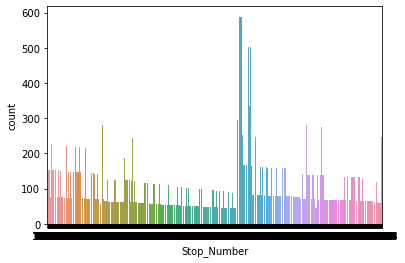

In [416]:
sns.countplot(x='Stop_Number', data=df_stop_features)

In [421]:
df_stop_features.Stop_Number.nunique()

1823

In [423]:
df_stop_features.Stop_Number.value_counts()

50093    588
50085    588
50073    588
50060    588
50019    588
        ... 
40777     44
40774     44
40773     44
40771     44
40873     44
Name: Stop_Number, Length: 1823, dtype: int64